In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn import mixture

In [3]:
p_matrices = []

dir_path_bc = r"bc_coincedence_matrices"
entries_control = os.listdir(dir_path_bc)


for file_name in entries_control[1:]:
    new_matr = np.loadtxt(dir_path_bc + fr"\{file_name}", delimiter=',').reshape(256, 256)
    p_matrices.append(new_matr)


In [4]:
import copy
P = copy.deepcopy(p_matrices[255])
print(P.max())

367.0


In [5]:
def t_(x, a, b):
    """[a,b] -> [0, 255]"""
    assert b > a
    m = 255 / (b - a)
    d = -255 * a / (b - a)
    
    return m * x + d

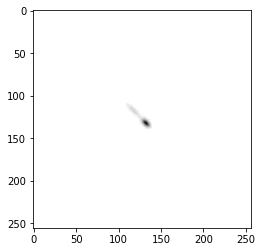

In [6]:
bad = P < 0.05 * P.max()
P[bad] = 0

# plt.figure(figsize=(10,10))
plt.imshow(P, cmap="gray_r")
plt.savefig("coincedence_matr_sample.png",dpi=200)

In [7]:
coords = []
for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        if P[i, j] > 0:
            coords.append((i, j))

In [8]:
#coords

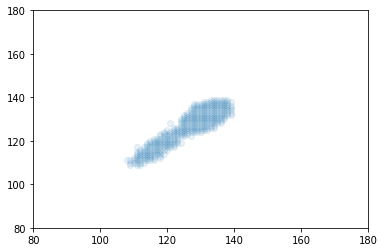

In [9]:
x_data = [x[0] for x in coords]
y_data = [x[1] for x in coords]

plt.xlim(80,180)
plt.ylim(80, 180)
plt.scatter(x_data, y_data, alpha=0.1)

In [10]:
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(coords)

In [11]:
coords1 = np.array(coords)
segmentation1 = np.array(gmm.predict(coords1), dtype=np.bool)
segmentation2 = np.array([True if not x else False for x in segmentation1])
segm1 = coords1[segmentation1]
segm2 = coords1[segmentation2]

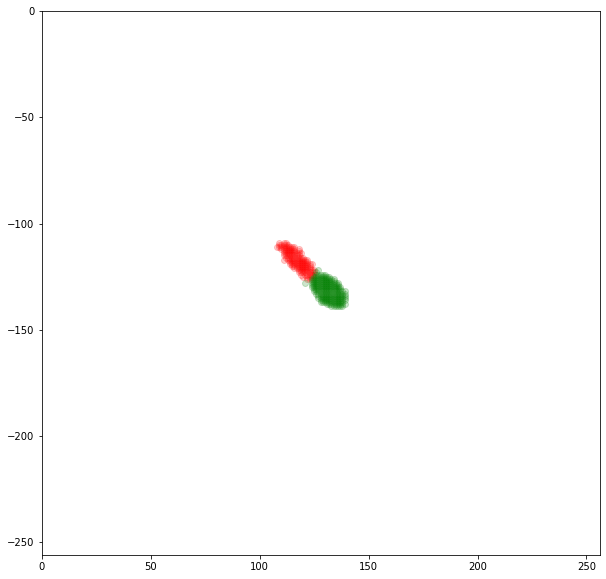

In [12]:
segm1_x = np.array([x[0] for x in segm1])
segm1_y = np.array([x[1] for x in segm1])

segm2_x = np.array([x[0] for x in segm2])
segm2_y = np.array([x[1] for x in segm2])
plt.figure(figsize=(10,10))
plt.xlim(0,256)
plt.ylim(-256, 0)

plt.scatter(segm1_x, -segm1_y, c="red", alpha=0.2)
plt.scatter(segm2_x, -segm2_y,c="green", alpha=0.2)
plt.savefig("segment_sample.png", dpi=200)

In [13]:
def barycenter(points: list((float, float))) -> (float, float):
    x_sum, y_sum = 0, 0
    for p in points:
        x_sum += p[0]
        y_sum += p[1]
    
    n = len(points)
    bcenter = (x_sum / n, y_sum / n)
    return bcenter

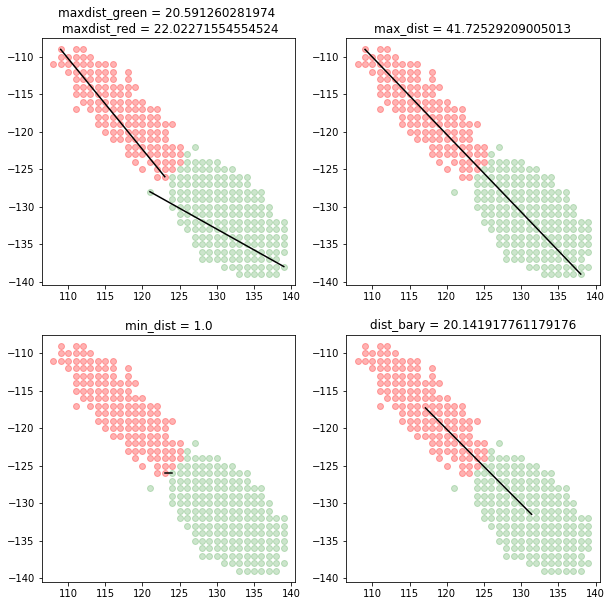

In [14]:
from scipy.spatial import distance
fig, axs = plt.subplots(2, 2, figsize=(10, 10), frameon=False)

# axs[0,0].set_x(80,180)
# axs[0,0].ylim(80, 180)

axs[0,0].scatter(segm1_x, -segm1_y, c="red", alpha=0.3)
axs[0,0].scatter(segm2_x, -segm2_y,c="green", alpha=0.2)

dists1 = distance.cdist(segm1, segm1, 'euclidean')
ind1 = np.unravel_index(np.argmax(dists1, axis=None), dists1.shape)

dists2 = distance.cdist(segm2, segm2, 'euclidean')
ind2 = np.unravel_index(np.argmax(dists2, axis=None), dists2.shape)

two_max_red = [(segm1[ind1[0]][0], -segm1[ind1[0]][1]),
               (segm1[ind1[1]][0], -segm1[ind1[1]][1])]
two_max_green = [(segm2[ind2[0]][0], -segm2[ind2[0]][1]), 
                 (segm2[ind2[1]][0], -segm2[ind2[1]][1])]

dist_max_green = distance.euclidean(two_max_green[0], two_max_green[1])
dist_max_red = distance.euclidean(two_max_red[0], two_max_red[1])

# макс расстояния внутри каждого кластера
p_x = [x[0] for x in two_max_red]
p_y = [x[1] for x in two_max_red]
# plt.scatter(p_x, p_y, c="blue")
axs[0,0].plot(p_x, p_y, c="black")

p_x = [x[0] for x in two_max_green]
p_y = [x[1] for x in two_max_green]
# plt.scatter(p_x, p_y, c="black")
axs[0,0].plot(p_x, p_y, c="black")
axs[0,0].set_title(f"maxdist_green = {dist_max_green} \n maxdist_red = {dist_max_red}")


# расстояния между центрами кластеров
# axs[1,1].xlim(80,180)
# axs[1,1].ylim(80, 180)

axs[1,1].scatter(segm1_x, -segm1_y, c="red", alpha=0.3)
axs[1,1].scatter(segm2_x, -segm2_y,c="green", alpha=0.2)
red_bary = barycenter(segm1)
green_bary = barycenter(segm2)
dist_bary = distance.euclidean(red_bary, green_bary)
# axs[1,1].scatter(red_bary[0], red_bary[1])
# axs[1,1].scatter(green_bary[0], green_bary[1])
axs[1,1].plot([red_bary[0], green_bary[0]], [-red_bary[1], -green_bary[1]], c="black")
axs[1,1].set_title(f"dist_bary = {dist_bary}")

# точки с макс расстоянием двух кластеров
# axs[0,1].xlim(80,180)
# axs[0,1].ylim(80, 180)

axs[0,1].scatter(segm1_x, -segm1_y, c="red", alpha=0.3)
axs[0,1].scatter(segm2_x, -segm2_y,c="green", alpha=0.2)
dists3 = distance.cdist(coords, coords, 'euclidean')
ind3 = np.unravel_index(np.argmax(dists3, axis=None), dists3.shape)
two_max = [(coords[ind3[0]][0], -np.array(coords[ind3[0]][1])),
          (coords[ind3[1]][0], -np.array(coords[ind3[1]][1]))]
dist_max = distance.euclidean(two_max[0], two_max[1])
p_x = [x[0] for x in two_max]
p_y = [x[1] for x in two_max]
axs[0,1].plot(p_x, p_y, color="black")
axs[0,1].set_title(f"max_dist = {dist_max}")

# точки с минимальным расстоянием между двумя кластерами
# axs[1,0].xlim(80,180)
# axs[1,0].ylim(80, 180)

axs[1,0].scatter(segm1_x, -segm1_y, c="red", alpha=0.3)
axs[1,0].scatter(segm2_x, -segm2_y,c="green", alpha=0.2)
dists4 = distance.cdist(segm1, segm2, 'euclidean')
ind4 = np.unravel_index(np.argmin(dists4, axis=None), dists4.shape)
two_min = [(segm1[ind4[0]][0], -np.array(segm1[ind4[0]][1])),
          (segm2[ind4[1]][0], -np.array(segm2[ind4[1]][1]))]
dist_min = distance.euclidean(two_min[0], two_min[1])

p_x = [x[0] for x in two_min]
p_y = [x[1] for x in two_min]
axs[1,0].plot(p_x, p_y, color="black")
axs[1,0].set_title(f"min_dist = {dist_min}")

fig.savefig(f'Illustration_apartsmall.png')